# Model from paper

In [2]:
#ResNet implementation
# import tensorflow as tf
# import random
# import time
# import numpy as np
# from keras.datasets import mnist
# import sys
# import os
# import itertools
# import sklearn.cluster
# import scipy.misc
# from time import time 
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical
# from keras.optimizers import adam_v2
# from keras.losses import categorical_crossentropy
# from tensorflow.keras.models import load_model
# from tensorflow.python.client import device_lib

# def make_model(filters=64, s1=5, s2=5, s3=3,
#                d1=0, d2=0, fc=256,
#                lr=1e-3, decay=1e-3):
#     model = Sequential()
#     model.add(Conv2D(filters, kernel_size=(s1, s1),
#                      activation='relu',
#                      input_shape=(28, 28, 1)))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(filters*2, (s2, s2), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters*2, (s3, s3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(d1))
#     model.add(Flatten())
#     model.add(Dense(fc, activation='relu'))
#     model.add(Dropout(d2))
#     model.add(Dense(10))
    
#     print("SUMMARY OF MODEL")
#     model.summary()
#     model.compile(optimizer='Adam',
#           loss='categorical_crossentropy',
#           metrics=['accuracy'])

#     final = Sequential()
#     final.add(model)
#     final.add(Activation('softmax'))
#     final.compile(optimizer='Adam',
#           loss='categorical_crossentropy',
#           metrics=['accuracy'])
        
    
    
#     return model, final

    
# def train_model(model, x_train, y_train, batch_size=512,epochs=10):
#     begin = time()
#     history=model.fit(x_train,to_categorical(y_train, 10),
#             batch_size=batch_size,
#             epochs=epochs,
#             shuffle=True,
#             verbose=2,
#             )
#     plt.plot(history.history['accuracy'])
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     print('Training time:',time()-begin)

#     return model

# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# img_rows = img_cols = 28
# x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
# x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255




# model, final = make_model()
# train_model(final,x_train, y_train)
# final.save("model_from_paper")









# Generate 1k perturbation-based adversarial examples on test images (LinfPGD)
Saved under npy/adversarial_examples_to_test_LinfPGD

In [3]:
from tensorflow.keras.models import load_model
import foolbox as fb
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

print("Tensorflow version: ",tf.__version__)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)


x_test = x_test.astype('float32')
x_test /= 255

model=load_model("model_from_paper")

number_of_attacks_to_test=1000


#assign model to foolbox
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))


# converting test data to type tensor
x_attack_to_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
x_attack_to_test=x_attack_to_test[:,:,:,np.newaxis]
y_attack_to_test=tf.convert_to_tensor(y_test, dtype=tf.int32)


attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack()
epsilon=0.1
#Adversarial examples to test...
_,advs_to_test, success=attack(fmodel, x_attack_to_test[0:number_of_attacks_to_test], y_attack_to_test[0:number_of_attacks_to_test], epsilons=epsilon)

print(np.shape(advs_to_test))

np.save("npy/adversarial_examples_to_test_LinfPGD", advs_to_test)

Tensorflow version:  2.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
(1000, 28, 28, 1, 1)


# Generate 10k perturbation-based adversarial examples on train images (LinfPGD)
Saved under npy/adversarial_examples_to_train_LinfPGD

In [4]:
from tensorflow.keras.models import load_model
import foolbox as fb
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

tf.config.list_physical_devices('GPU')
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)


x_train = x_train.astype('float32')

x_train /= 255


model=load_model("model_from_paper")

number_of_attacks_to_train=2000


#assign model to foolbox
fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))



#converting training data to type tensor
x_attack_to_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_attack_to_train=x_attack_to_train[:,:,:,np.newaxis]
y_attack_to_train=tf.convert_to_tensor(y_train, dtype=tf.int32)
attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack()

#Adversarial examples to train...
epsilon=0.1
_,advs, success=attack(fmodel, x_attack_to_train[0:number_of_attacks_to_train], y_attack_to_train[0:number_of_attacks_to_train], epsilons=epsilon)
_,advs1, success=attack(fmodel, x_attack_to_train[number_of_attacks_to_train:number_of_attacks_to_train*2], y_attack_to_train[number_of_attacks_to_train:number_of_attacks_to_train*2], epsilons=epsilon)      
_,advs2, success=attack(fmodel, x_attack_to_train[number_of_attacks_to_train*2:number_of_attacks_to_train*3], y_attack_to_train[number_of_attacks_to_train*2:number_of_attacks_to_train*3], epsilons=epsilon)      
_,advs3, success=attack(fmodel, x_attack_to_train[number_of_attacks_to_train*3:number_of_attacks_to_train*4], y_attack_to_train[number_of_attacks_to_train*3:number_of_attacks_to_train*4], epsilons=epsilon)    
_,advs4, success=attack(fmodel, x_attack_to_train[number_of_attacks_to_train*4:number_of_attacks_to_train*5], y_attack_to_train[number_of_attacks_to_train*4:number_of_attacks_to_train*5], epsilons=epsilon)    
advs_to_train=tf.concat([advs,advs1, advs2, advs3, advs4],0)

print(np.shape(advs_to_train))

np.save("npy/adversarial_examples_to_train_LinfPGD", advs_to_train)

(10000, 28, 28, 1, 1)


# Attack Model from Paper and Retrain with adversarial examples

1000/1000 [==============================] - 3s 3ms/step - loss: 0.0290 - accuracy: 0.9921
Test accuracy: 0.9921000003814697
100/100 [==============================] - 0s 3ms/step - loss: 1.8305 - accuracy: 0.5930
Test accuracy adversarial: 0.5929999947547913
ADVERSARIAL IMAGES


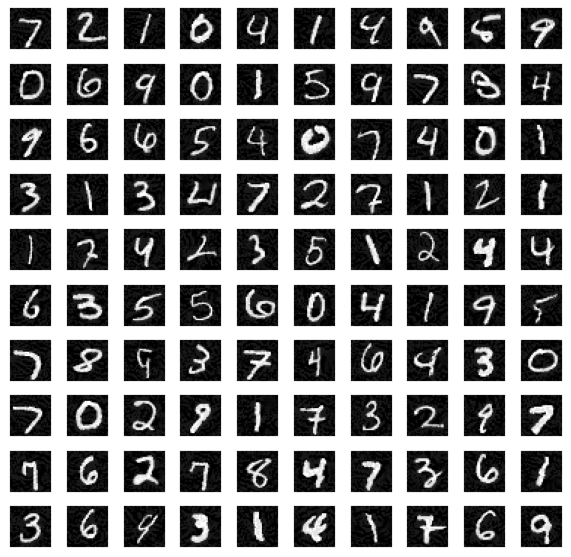

10000
Retraining with 10000 Adversarial Examples...
Epoch 1/10
20/20 - 1s - loss: 0.2932 - accuracy: 0.9320 - 1s/epoch - 66ms/step
Epoch 2/10
20/20 - 0s - loss: 0.0564 - accuracy: 0.9808 - 290ms/epoch - 15ms/step
Epoch 3/10
20/20 - 0s - loss: 0.0237 - accuracy: 0.9922 - 289ms/epoch - 14ms/step
Epoch 4/10
20/20 - 0s - loss: 0.0104 - accuracy: 0.9979 - 290ms/epoch - 15ms/step
Epoch 5/10
20/20 - 0s - loss: 0.0058 - accuracy: 0.9993 - 290ms/epoch - 15ms/step
Epoch 6/10
20/20 - 0s - loss: 0.0029 - accuracy: 0.9999 - 302ms/epoch - 15ms/step
Epoch 7/10
20/20 - 0s - loss: 0.0019 - accuracy: 0.9999 - 314ms/epoch - 16ms/step
Epoch 8/10
20/20 - 0s - loss: 0.0012 - accuracy: 1.0000 - 335ms/epoch - 17ms/step
Epoch 9/10
20/20 - 0s - loss: 8.9339e-04 - accuracy: 1.0000 - 328ms/epoch - 16ms/step
Epoch 10/10
20/20 - 0s - loss: 7.2899e-04 - accuracy: 1.0000 - 322ms/epoch - 16ms/step
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0370 - accuracy: 0.9894
Test accuracy: 0.98940002918243

In [5]:

from tensorflow.keras.models import load_model
import foolbox as fb
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


advs_to_test=np.load("npy/adversarial_examples_to_test_LinfPGD.npy")
model=load_model("model_from_paper")




(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)


x_test = x_test.astype('float32')
x_test /= 255


#one-hot-encode y_test to test model
y_test=to_categorical(y_test)


def test_model(number_of_attacks_to_test):
    #test with original test data
    acc = model.evaluate(x_test, y_test,
                                batch_size=10)
    print('Test accuracy:', acc[1])

    #test with adversarial data
    acc = model.evaluate(advs_to_test, y_test[0:number_of_attacks_to_test],
                                batch_size=10)
    print('Test accuracy adversarial:', acc[1])




test_model(number_of_attacks_to_test=1000)
#plot adversarial images
print("ADVERSARIAL IMAGES")
_, ax = plt.subplots(10, 10, figsize=(10, 10))

for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    x=advs_to_test[i]
    x=x[:,:,0,0]
    temp[2:-2, 2:-2, 0] = x
    temp[2:-2, 2:-2, 1] = x
    temp[2:-2, 2:-2, 2] = x
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')

plt.show()

# print("ORIGINAL IMAGES")
# _, ax = plt.subplots(10, 10, figsize=(10, 10))
# for i in range(100):
#     temp = np.ones((32, 32, 3), dtype=np.float32)
#     x=x_test[i]
#     x=x[:,:,0]
#     temp[2:-2, 2:-2, 0] = x
#     temp[2:-2, 2:-2, 1] = x
#     temp[2:-2, 2:-2, 2] = x
#     ax[i//10, i%10].imshow(temp)
#     ax[i//10, i%10].axis('off')

# plt.show()


#RETRAIN MODEL WITH ADVERSARIAL EXAMPLES...
advs_to_retrain=np.load("npy/adversarial_examples_to_train_LinfPGD.npy")
print(len(advs_to_retrain))

count_advs_to_retrain=10000
assert len(advs_to_retrain)>=count_advs_to_retrain and count_advs_to_retrain>0
print("Retraining with {} Adversarial Examples...".format(count_advs_to_retrain))
#retraining with adversarial images
model.fit(advs_to_retrain[0:count_advs_to_retrain],to_categorical(y_train[0:count_advs_to_retrain]),
            batch_size=512,
            epochs=10,
            shuffle=True,
            verbose=2,)
test_model(number_of_attacks_to_test=1000)


# Testing invariance based adversarial examples from paper (100 labels from 40 human participants)


INVARIANCE BASED ADVERSARIAL IMAGES


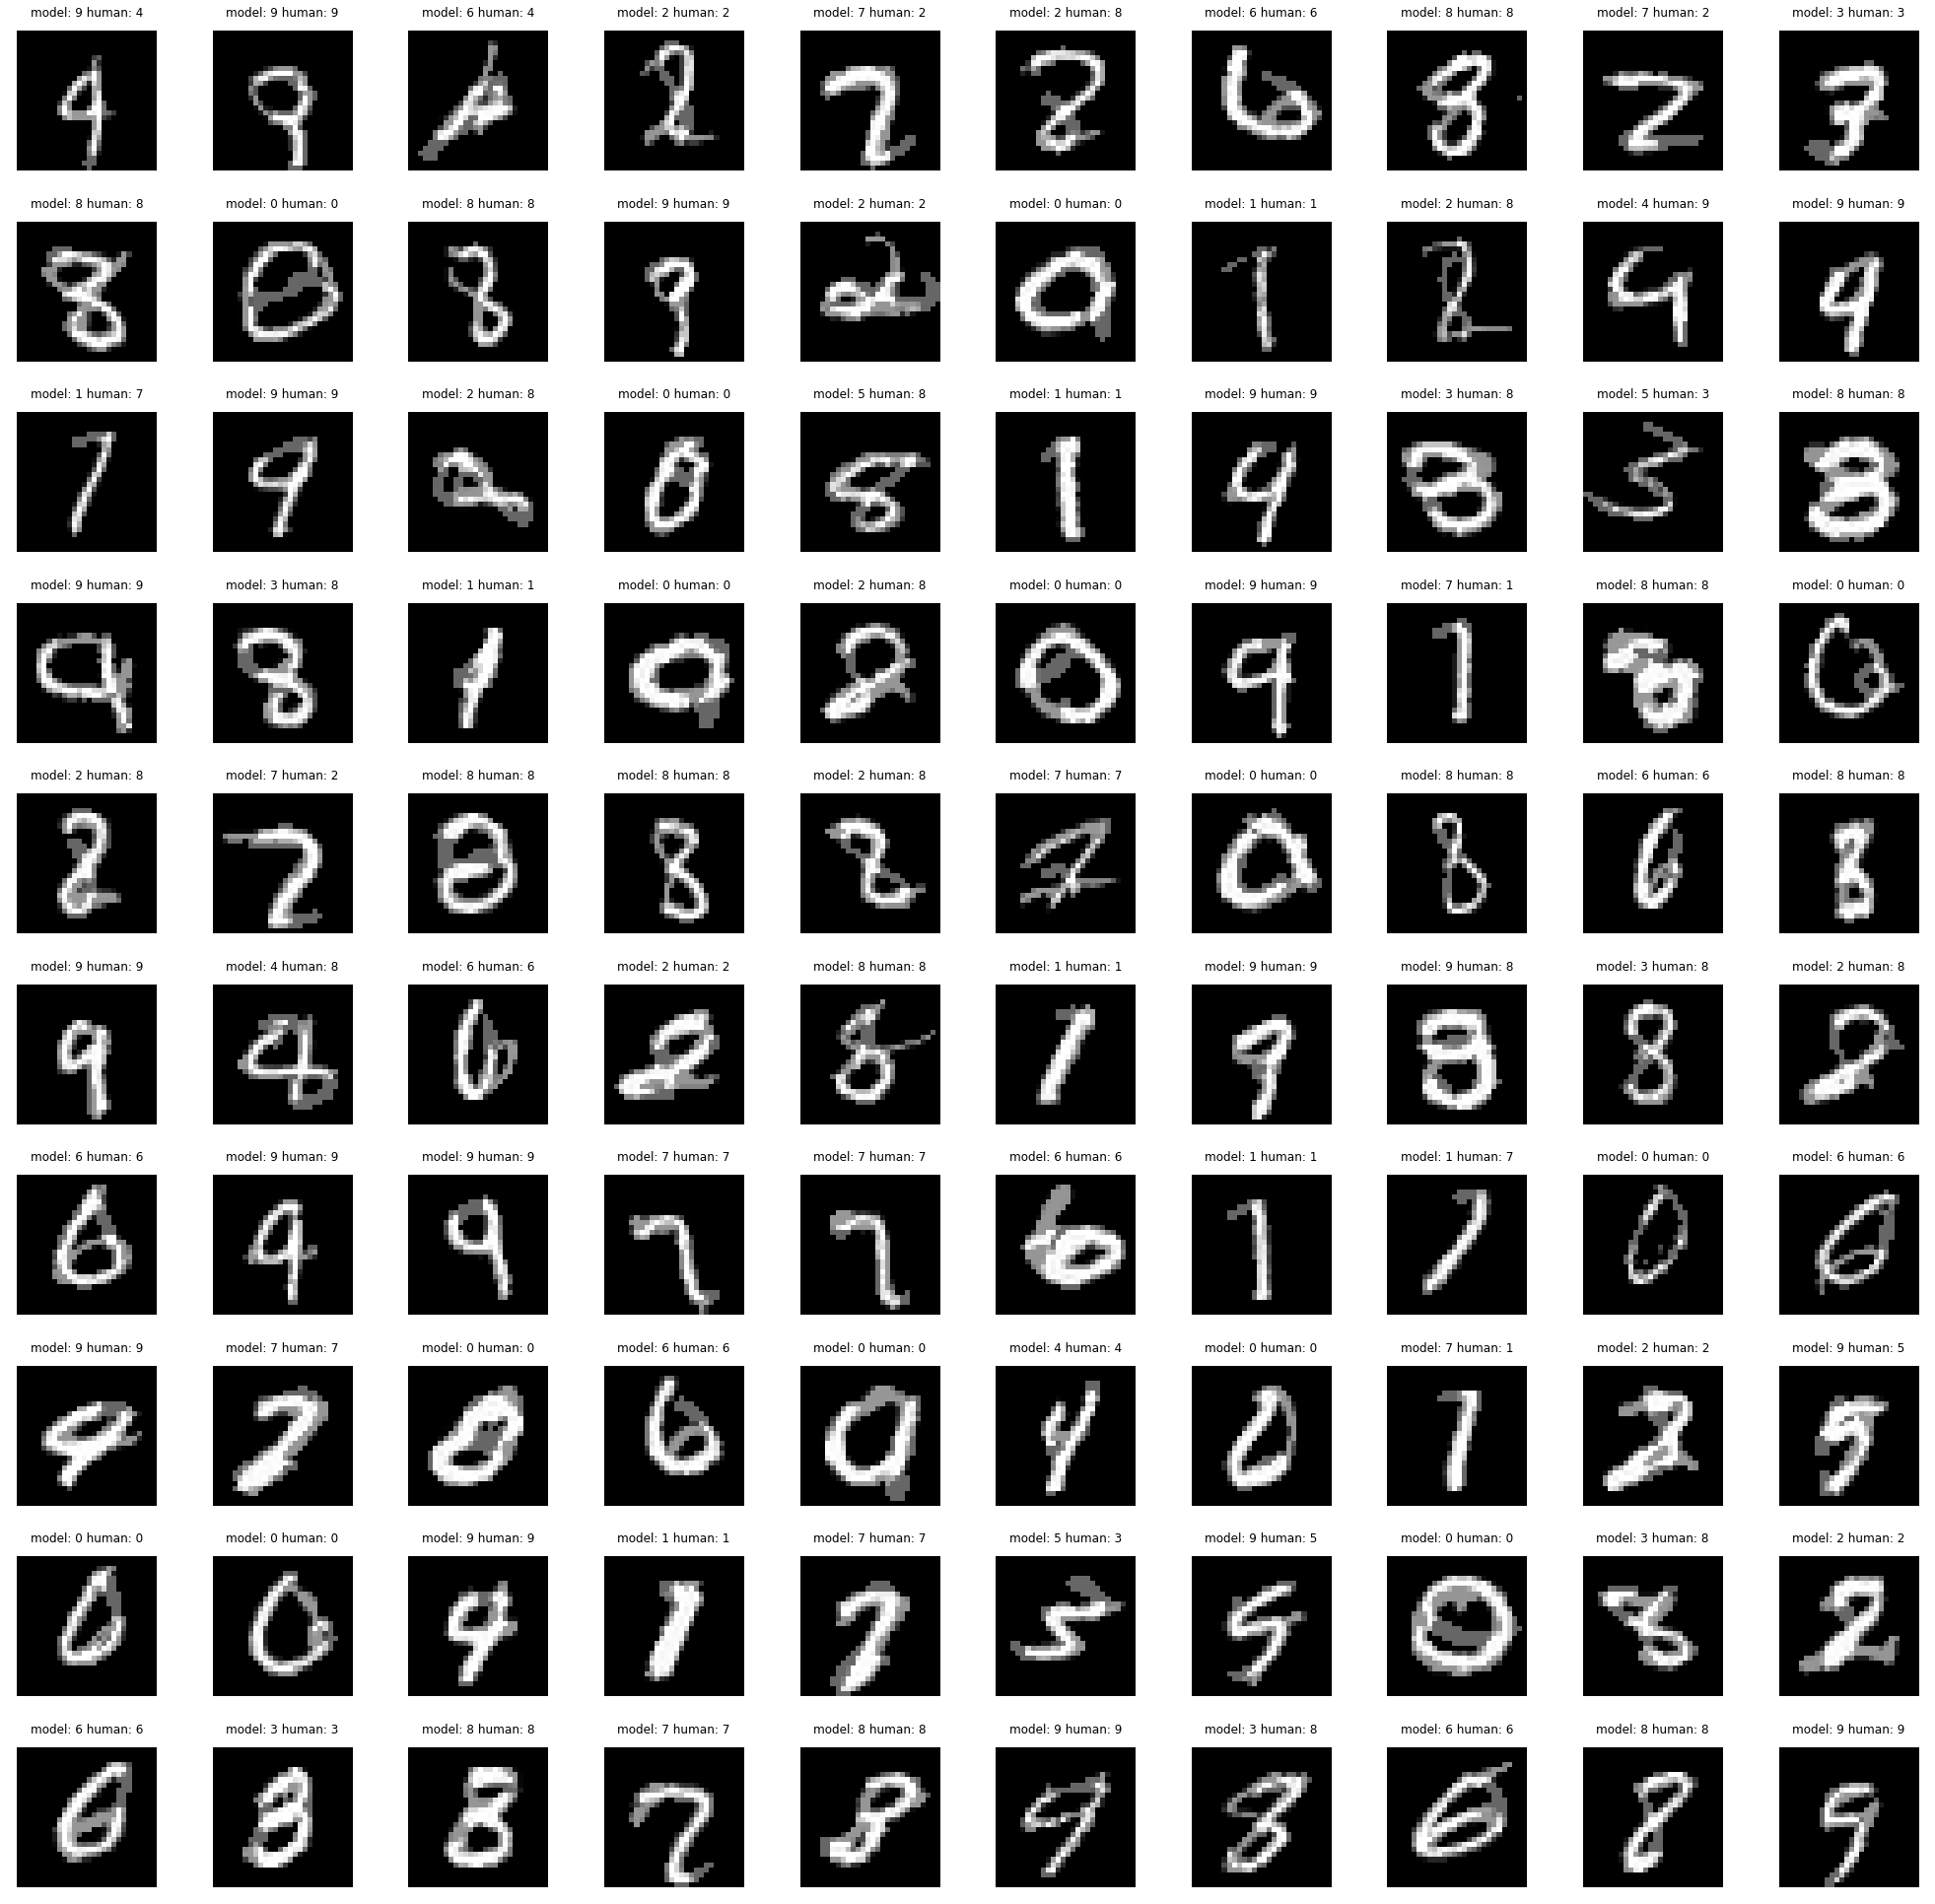

Human disagreeing: 28.999999999999996%


In [6]:
#Get model untrained with adversarial examples...
model=load_model("model_from_paper")


#get invariance-based adversarial examples generated from tramer et al.
adv_03 = np.load('invariance_examples/linf/automated_eps04.npy').astype(np.float32) / 255.
#get the human labels from tramer et.al
labels_h_03 = np.load('invariance_examples/linf/automated_eps04_labels.npy')

labels_h_03=to_categorical(labels_h_03)




print("INVARIANCE BASED ADVERSARIAL IMAGES")
disagreeing_human=0

#let my model predict with the invariance-based adversarial examples
predictions=model.predict(adv_03)
_, ax = plt.subplots(10, 10, figsize=(35, 35))
for i in range(100):
    temp = np.ones((32, 32, 3), dtype=np.float32)
    x=adv_03[i]
    # x=x[:,:,0]
    human_labeled=np.argmax(labels_h_03[i])
    temp[2:-2, 2:-2, 0] = x
    temp[2:-2, 2:-2, 1] = x
    temp[2:-2, 2:-2, 2] = x
    ax[i//10, i%10].imshow(temp)
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title("model: {} human: {}".format(np.argmax(predictions[i]), human_labeled))
    #check if human prediction differs from model prediction
    if human_labeled!=np.argmax(predictions[i]):
        disagreeing_human+=1

plt.show()

print("Human disagreeing: {}%".format(disagreeing_human/100*100))



# Save random 200 indices in file...
Needed to generate invariance based adversarial examples

In [7]:
rand_indices = np.random.randint(0,9999,(200))
np.save("npy/random_indices200", rand_indices)





# Find nearest Neighbours (Takes a lot of computation)

In [8]:
from keras.datasets import mnist
import numpy as np
from sklearn.neighbors import NearestNeighbors
from itertools import product
from scipy.ndimage.interpolation import rotate, shift

#  Load the MNIST data. 100 randomly chosen test points
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
idxs = np.load("npy/random_indices200.npy")
assert len(idxs) == 200
test_xs = X_test[idxs]
test_ys = Y_test[idxs]

# build a nearest neighbors classifier per class
N = 1
all_NNs = []

for i in range(10):
    #Reshape to 1D (28*28=784)
    X = X_train[Y_train == i].reshape(-1, 784)
    print("X: ", np.shape(X))
    nn = NearestNeighbors(n_neighbors=N)
   
    nn.fit(X)
    all_NNs.append(nn)
print(all_NNs)



# Rotation-translation parameters
limits = [3, 3, 30]
granularity = [5, 5, 31]
grid = list(product(*list(np.linspace(-l, l, num=g) for l, g in zip(limits, granularity))))

# tries all rotation-translations of the input and returns the closest neighbor from each class
def get_best_neighbors(x, y):
    xs = [shift(rotate(x, r, reshape=False), (tx, ty)).reshape(784) for (tx, ty, r) in grid]
    xs = np.asarray(xs.copy())
    
    nns = []
    y_nns = []
    grids_nn = []
    
    # find a nearest neighbor in each class
    for i in range(10):
        if i != y:
            X = X_train[Y_train == i]
            Y = Y_train[Y_train == i]
            distances, indices = all_NNs[i].kneighbors(xs, n_neighbors=1)

            best = np.argmin(np.reshape(distances, -1))
            best_idx = np.reshape(indices, -1)[best]
            nns.append(X[best_idx])
            y_nns.append(Y[best_idx])
            
            # store the inverse rotation+translation to be applied to the target
            grids_nn.append(-np.asarray(grid[best]))
    
    return nns, y_nns, grids_nn


all_nns = []
all_y_nns = []
all_grids_nns = []

# find nearest neighbors for some test inputs (this takes a little while)
for i in range(len(idxs)):
    if i % 10 == 0:
        print("{}/{} done".format(i, len(idxs)))
    x = test_xs[i]
    y = test_ys[i]

    # find the nearest neighbors for each class, with the corresponding rotation and translation
    nns, y_nns, grids_nns = get_best_neighbors(x, y)
    nn_advs = [shift(rotate(nn, r, reshape=False), (tx, ty)) for (nn, (tx, ty, r)) in zip(nns, grids_nns)]
    all_nns.append(nn_advs)
    all_y_nns.append(y_nns)
    all_grids_nns.append(np.asarray(grids_nns))

X:  (5923, 784)
X:  (6742, 784)
X:  (5958, 784)
X:  (6131, 784)
X:  (5842, 784)
X:  (5421, 784)
X:  (5918, 784)
X:  (6265, 784)
X:  (5851, 784)
X:  (5949, 784)
[NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1), NearestNeighbors(n_neighbors=1)]
0/200 done
10/200 done
20/200 done
30/200 done
40/200 done
50/200 done
60/200 done
70/200 done
80/200 done
90/200 done
100/200 done
110/200 done
120/200 done
130/200 done
140/200 done
150/200 done
160/200 done
170/200 done
180/200 done
190/200 done


# Save nearest Neighbours

In [9]:
# save everything!
np.save("X_test_200.npy", test_xs)
np.save("all_nns.npy", np.asarray(all_nns))
np.save("all_y_nns.npy", np.asarray(all_y_nns))
np.save("all_grids_nns.npy", np.asarray(all_grids_nns))

print(np.shape(test_xs))

(200, 28, 28)


In [10]:
def linf_attack(x, nn_adv, eps=0.3):
    x_adv = x.copy().astype(np.float32)
    nn_adv = nn_adv.astype(np.float32)
    
    # if possible, change the pixels to the target value
    idx = np.where((np.abs(nn_adv - x) <= eps*255.) & (x > 0))
    x_adv[idx] = nn_adv[idx]
    
    # otherwise, go as close as possible
    idx = np.where(np.abs(nn_adv - x) > eps*255.)
    sign = np.sign(nn_adv - x)
    x_adv[idx] += sign[idx] * eps * 255.
    
    x_adv = np.clip(x_adv, x.astype(np.float32) - eps*255, x.astype(np.float32) + eps*255)
    x_adv = np.clip(x_adv, 0, 255.)
    
    return x_adv

# Generate invariance based adversarial examples

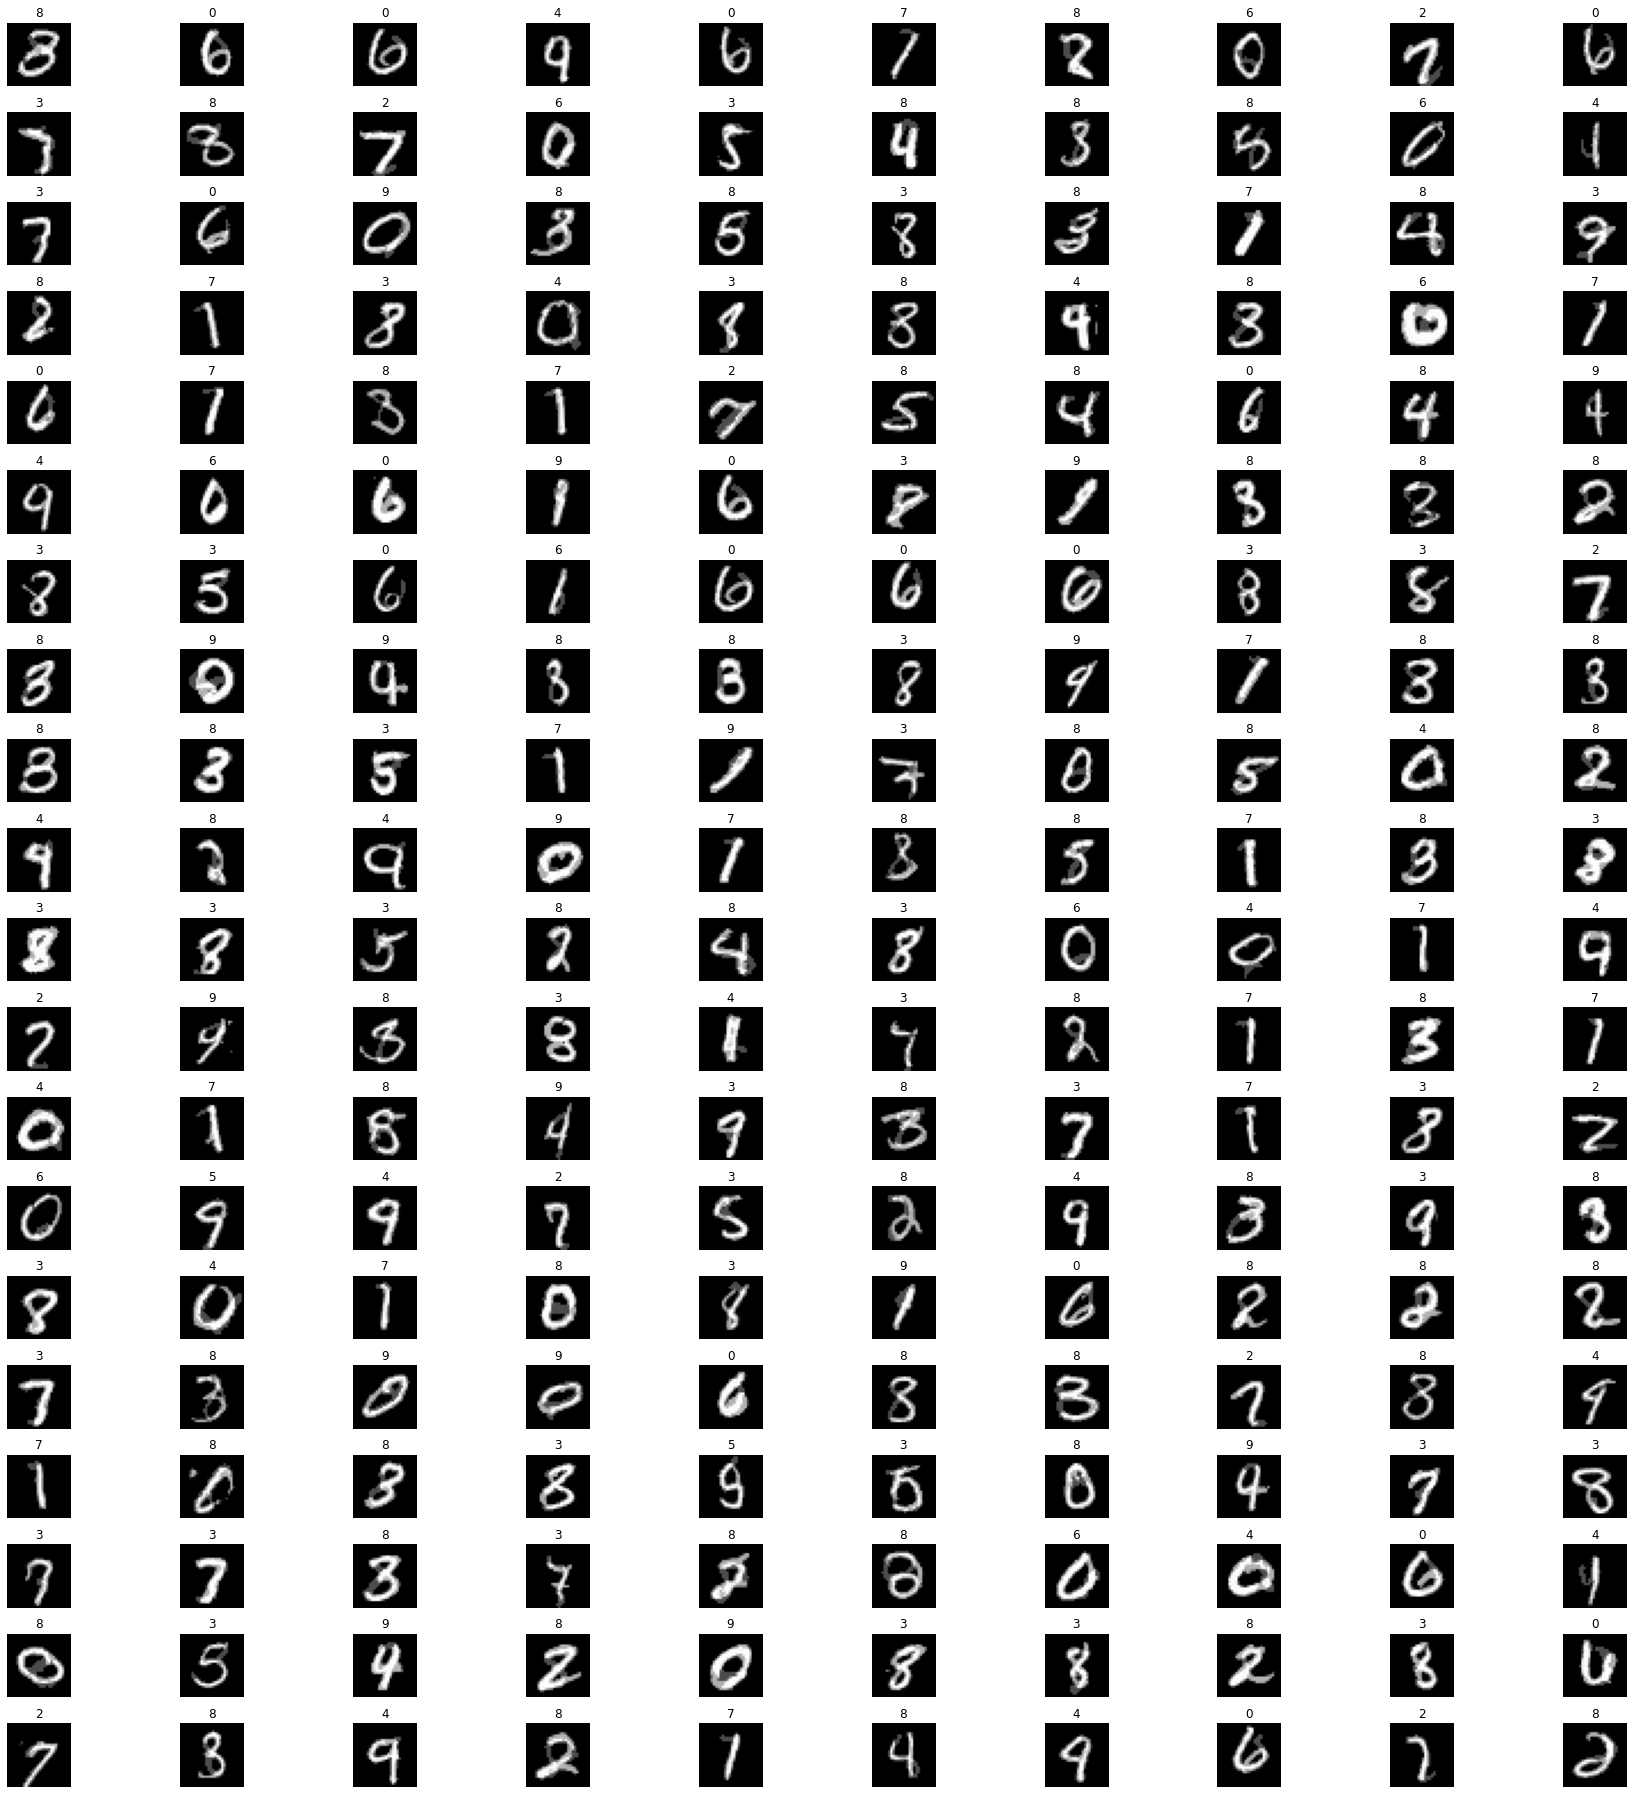

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
all_nns=np.load("all_nns.npy")
all_y_nns=np.load("all_y_nns.npy")
all_grids_nns=np.load("all_grids_nns.npy")
test_xs=np.load("X_test_200.npy")
idxs = np.load("npy/random_indices200.npy")
assert len(idxs) == 200

test_ys = Y_test[idxs]
# fig, ax = plt.subplots(max(len(all_nns), 2), len(all_nns[0])+2, 
#                        figsize=(10*2, len(all_nns)*1.5))
# [a.axis('off') for a in np.asarray(ax).reshape(-1)]

# manually chosen target classes for each source class
targets = {
    0: [4, 6, 8, 9],
    1: [4, 6, 7, 9],
    2: [8],
    3: [8],
    4: [8, 9],
    5: [3, 8],
    6: [0],
    7: [2, 3],
    8: [3],
    9: [3, 4, 5]
}

best_y_advs = []
best_targets = []
best_advs = []

for i in range(len(all_nns)):
    x = test_xs[i]
    y = test_ys[i]
    # ax[i, 0].imshow(255-x, cmap='gray', vmin=0, vmax=255)
    
    best_x_adv = None
    best_nn_adv = None
    amount_removed = []
    amount_added = []
    rot = []
    best_y = None
    min_removed = np.inf
    for j in range(len(all_nns[i])):
        nn_adv = all_nns[i][j]
        y_nn = all_y_nns[i][j]
        x_adv = linf_attack(x, nn_adv, eps=0.3)
        # ax[i, 1+y_nn].imshow(255-x_adv, cmap='gray', vmin=0, vmax=255)
        
        # retain the target that required the least amount of pixels to be "removed"
        curr_rot = np.abs(all_grids_nns[i][j][-1])
        curr_removed = np.sum(np.abs(np.maximum(x/255. - x_adv/255., 0)))
        
        if y_nn in targets[y] and curr_removed < min_removed:
            min_removed = curr_removed
            best_y = y_nn
            best_x_adv = x_adv
            best_nn_adv = (nn_adv, y_nn)
                
    best_targets.append(best_nn_adv)
    best_advs.append(best_x_adv)
    best_y_advs.append(best_y)
# print("BEST Y: ", np.shape(best_advs))
# print("BEST X: ",np.shape(best_y_advs))

_, ax = plt.subplots(20, 10, figsize=(25, 25))
j=0
for i in range(200):
    x=best_advs[i]
    if i>0:
        if i%10==0:
            j+=1
    # print("ax[{},{}]".format(j, i%10))
    
    ax[j, i%10].imshow(x,cmap='gray')
    ax[j, i%10].axis('off')
    ax[j,i%10].set_title(best_y_advs[i])
# for i in range(200):
#     temp = np.ones((32, 32, 3), dtype=np.float32)
#     x=best_advs[i]
#     # x=x[:,:,0]
#     # temp[2:-2, 2:-2, 0] = x
#     # temp[2:-2, 2:-2, 1] = x
#     # temp[2:-2, 2:-2, 2] = x
#     print("ax[{},{}]".format(i//20, i%10))
#     ax[i//20, i%10].imshow(x)
#     ax[i//20, i%10].axis('off')
_.tight_layout(pad=1.0)
plt.show()

np.save("npy/invariance-based_adversarial_examples", best_advs)
np.save("npy/invariance-based_adversarial_examples_labels", best_y_advs)
